In [2]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle

from astropy.io import fits
from astropy import wcs
import pickle

import sys
import imp
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils
imp.reload(cat_utils)
from scipy.optimize import curve_fit
import scipy

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace
from scipy.linalg import sqrtm,inv

In [3]:
# LOAD LITERATURE IR POWER SPECTRA (Zemcov+ 14)

dat_dir = '../zemcov14_data/'
ell_Cell_ciber = np.genfromtxt(dat_dir+'zemcov14_CIBER_data_with_errors_Cl.txt',skip_header=4,delimiter=',')
ell_Cell_eormodel = np.genfromtxt(dat_dir+'zemcov14_eor_Cl.txt',skip_header=1,delimiter=',')

# these are in nW/m^2/sr, but I want to convert them to kJy/sr
# I have to divide by the bandwidth of 0.5um
lamda_m = 1.1e-6
freq_Hz = 3.e8/lamda_m
convert_to_kJy_per_sr = 1.e-9/freq_Hz/(1.e3*1.e-26)

ell_Cell_ciber[:,1] *= convert_to_kJy_per_sr
ell_Cell_eormodel[:,1] *= convert_to_kJy_per_sr

In [4]:
label_groups = [ \
'02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I', \
'02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I',\
'02a57694o0301I 02a57694o0305I 02a57694o0309I 02a57694o0321I 02a57694o0325I 02a57694o0329I 02a57694o0341I 02a57694o0345I 02a57694o0349I',\
'02a57694o0300I 02a57694o0304I 02a57694o0308I 02a57694o0320I 02a57694o0324I 02a57694o0328I 02a57694o0340I 02a57694o0344I 02a57694o0348I']

analysis_names = ['_'.join([l.split('o')[1] for l in labelgroup.split()]) for labelgroup in label_groups]
print(analysis_names)

run = 'ATLAS_mwa57694_rereduction'
xcor_data_dir = '/home/abrahamn/xcor_data/'
raw_frames_root = xcor_data_dir+run+'/'
analysis_roots = [xcor_data_dir+'analysis/'+run+'/' + a + '/' for a in analysis_names]
print(analysis_names)

['0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I', '0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I', '0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I', '0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I']
['0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I', '0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I', '0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I', '0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I']


In [5]:
secats = []
for i in range(4):
    secat = cat_utils.IRCatalog(se_path=analysis_roots[i]+analysis_names[i]+'.sex',se_magzpt=20.46)
    g = secat.jy_all>1.e-10
    secat = cat_utils.Catalog(secat.ra_all[g],secat.dec_all[g],secat.jy_all[g],a=secat.a[g],b=secat.b[g])
    
    secats.append(secat)

loading/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I.sex
loading/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I/0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I.sex
loading/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I/0301I_0305I_0309I_0321I_0325I_0329I_0341I_0345I_0349I.sex
loading/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I/0300I_0304I_0308I_0320I_0324I_0328I_0340I_0344I_0348I.sex


(2.7401479326601912, -24.789017138633387)


(357.24780231196945, -24.689997090704114)


(2.8473810974648135, -29.130555545466265)


(357.1338790636421, -29.228966964566052)


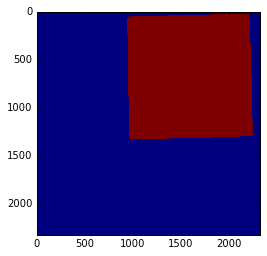

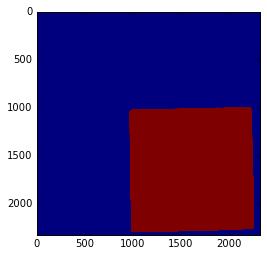

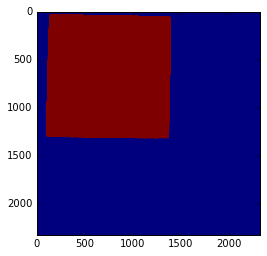

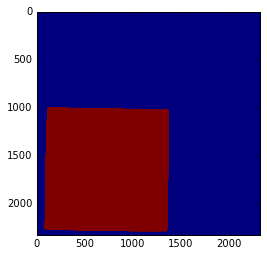

In [6]:
imgs = []
ws = []
x_meds = []
y_meds = []
racents = []
deccents = []

for i in range(4):
    img_fits_path = analysis_roots[i]+analysis_names[i]+'.fits'

    hdulist_img = fits.open(img_fits_path)
    img = hdulist_img[0].data
    h = hdulist_img[0].header
    n = img.shape[0]
    hdulist_img.close()
    w = wcs.WCS(h)
    asec_per_pixel = np.abs(h['CD1_1'])*3600
    
    plt.figure()
    plt.imshow(img[::10,::10]>0)

    x,y = np.where(img != 0)
    x_med, y_med = int(np.median(x)),int(np.median(y))
    
    radeccent = w.wcs_pix2world(x_med,y_med,0)
    racent,deccent = 1.*radeccent[0],1.*radeccent[1]
    print(racent,deccent)
    
    imgs.append(img)
    ws.append(w)
    x_meds.append(x_med)
    y_meds.append(y_med)
    racents.append(racent)
    deccents.append(deccent)

In [7]:
def mask_circle_in_image(m,xcent,ycent,r):    
    if r == 0: return
    
    n=m.shape[0]
    if not ((0<=xcent<n) and (0<=ycent<n)): return
    for y in range(-int(r),int(r)+1): # x is the x distance from circle center
        if not (0 <= ycent+y < n): continue
        #print(n)
        #print(int(xcent-np.sqrt(r**2-y**2)),int(xcent+np.sqrt(r**2-y**2)))
        #rint(max(0,int(xcent-np.sqrt(r**2-y**2))),min(n,int(xcent+np.sqrt(r**2-y**2))),)
        m[ycent+y,max(0,int(xcent-np.sqrt(r**2-y**2))):min(n,int(xcent+np.sqrt(r**2-y**2)))] = 0
        
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,min_fraction_unmasked=.5,gauss_fit_min=.1,bin_method='fit'): # or 'avg'
    img_binned = np.zeros((n_coarse,n_coarse))
    
    binedges = np.linspace(300,400,200) # for the hist gaussian fitting
    
    print(bin_method)
    
    for i in range(n_coarse):
        if i % 15 == 0: print('%1.3f '%(1.*i/n_coarse)),
        for j in range(n_coarse):
            img_in_this_coarse_bin = img[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
            mask_in_this_coarse_bin = mask[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
            if np.any(img_in_this_coarse_bin==0) or np.sum(mask_in_this_coarse_bin)<min_fraction_unmasked*coarse_bin_factor**2: continue

            unmasked_img_vals = img_in_this_coarse_bin[1==mask_in_this_coarse_bin]
                
            if bin_method == 'avg':
                img_binned[i,j] = np.mean(unmasked_img_vals)
            elif bin_method == 'fit':
                counts,binedges = np.histogram(unmasked_img_vals,binedges)
                bins = .5*(binedges[1:]+binedges[:-1])
                g = counts>np.max(counts)*gauss_fit_min

                try:
                    coeff, var_matrix = curve_fit(gauss, bins[g], counts[g],\
                                                  p0=[np.max(counts),np.median(img_in_this_coarse_bin[1==mask_in_this_coarse_bin]),10],\
                                                  sigma=np.sqrt(counts[g]))
                    img_binned[i,j] = coeff[1]
                except:
                    pass
    return img_binned

In [8]:
def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, sqrt(np.mean(w2**2))

def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def vec2arr(v):
    return np.array(v).flatten()

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=False,filt_small_lx_and_ly_bins=False):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    dl = np.abs(lvals[1]-lvals[0])
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))
    ft_mask = (np.abs(lx)>2*dl)&(np.abs(ly)>2*dl)

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= ft_mask
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def img2optPS(img_meas,pguess_method,dtheta_rad,nbins,lmin,lmax,uselogbins=True,interp_pguess=False,verbose=False,filt_small_lx_and_ly_bins=False):
    n = img_meas.shape[0]
    norm = (dtheta_rad**2)/(n**2)*n**4
    xir = matrix(img_meas.flatten()).T

    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)

    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    dl = np.abs(lvals[1]-lvals[0])
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)

    if verbose:
        for bini in range(nbins):
            if filt_small_lx_and_ly_bins:
                smallell = (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])&smallell),lbincenters[bini]))
            else:
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])),lbincenters[bini]))
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)
        return Ccommabini
    #Ccomma_mats = [gen_Ccommabini(bini) for bini in range(nbins)]


    # put in a guess of the data covariance
    print('a '),
    # generate the fourier transform matrix
    lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
    lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
    F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2
    
    if pguess_method == 'zemcov':
        pguess = np.interp(lbincenters,ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1]**2/ell_Cell_ciber[1::3,0]**2)
    else:
        pguess = 1./lbincenters**pguess_method
    
    Cguess_ft = matrix(np.diag( 10.**np.interp(np.log10(lmaggrid.flatten()),np.log10(lbincenters),np.log10(pguess/norm/n**2)) ))   
    Csignal = F*Cguess_ft*conj(F).T
            
    print('c '),
    Cmask = 1.e5*np.matrix(np.diag(img_meas.flatten()==0)) # IS THIS A REASONABLE NUMBER ??
    print('d '),
    Cinv = inv(Csignal + Cmask)

    print('e '),
    # calculate q_alpha
    q = np.matrix(np.zeros((nbins,1)))
    Ccomma_times_Cinv_mats = []
    print('\nbins: '),
    for bini in range(nbins):
        print(bini),
        Ccommabini_times_Cinv = gen_Ccommabini(bini)*Cinv
        Ccomma_times_Cinv_mats.append(Ccommabini_times_Cinv)
        q[bini] = .5*real(xir.T*Cinv*Ccommabini_times_Cinv*xir).item()

    # calculate Fisher matrix

    Fish = np.matrix(np.zeros((nbins,nbins)))
    print('\nfisher row: '),
    for i in range(nbins):
        print(i),
        for j in range(i,nbins):
            Fish[i,j] = np.real(.5*trace(Ccomma_times_Cinv_mats[i]*Ccomma_times_Cinv_mats[j]))
            Fish[j,i] = Fish[i,j]
    
    p0 = vec2arr(sqrtm(inv(Fish))*q)*norm/vec2arr(np.max(sqrt(Fish),axis=0))
    p1 = vec2arr(inv(Fish)*q*norm)

    return lbincenters,p0,Fish

In [9]:
def rawimg2pspec(img,w,secat,mask_coef1=10,mask_coef2=12,mask_above_median_adu_plus=1.e9,\
             target_coarse_res_amin=3.5,min_fraction_unmasked=.5,gauss_fit_min=.1,\
             fov_deg=4.,ps_method='oqe',filt_small_lx_and_ly_bins=True,lmin=350,lmax=4360,nbins=8,\
             uselogbins=True,use_fft_hann=False,masked_img_zoom_skip=1,bin_method='avg',pguess_method='zemcov',max_adu=25000.,mask_rad_asec_around_max_adu=400.):
    
    mask = np.ones(img.shape)
    px,py = w.wcs_world2pix(secat.ra,secat.dec,1)

    print('masking sources')
    for i in range(len(secat.ra)):
        if i % 2500 == 0: print('%1.3f '%(1.*i/len(secat.ra))),
        mask_circle_in_image(mask,px[i],py[i],mask_coef1*secat.jy[i]/asec_per_pixel+mask_coef2*min(secat.a[i],secat.b[i]))
    
    print('masking around nearly saturated pixels')
    xbad,ybad = np.where(img>max_adu)
    for i in range(len(xbad)):
        if i % 2500 == 0: print('%1.3f '%(1.*i/len(xbad))),
        mask_circle_in_image(mask,ybad[i],xbad[i],mask_rad_asec_around_max_adu/asec_per_pixel)
    
    mask *= img < mask_above_median_adu_plus + np.median(img[img>0]) # to active this, set mask_above_median_adu_plus = 10    
    
    dd = 300
    x,y = np.where(img != 0)
    x_med, y_med = int(np.median(x)),int(np.median(y))
    x0,x1 = x_med-dd,x_med+dd
    y0,y1 = y_med-dd,y_med+dd
    skip = masked_img_zoom_skip
    masked_img_zoom = img[x0:x1:skip,y0:y1:skip]*mask[x0:x1:skip,y0:y1:skip]
    
    target_coarse_res_asec = target_coarse_res_amin*60
    fine_pixel_asec = 1.86
    coarse_bin_factor = int(np.round(target_coarse_res_asec/fine_pixel_asec))
    dtheta_coarse_rad = fine_pixel_asec*coarse_bin_factor/3600*np.pi/180

    n_coarse = int(np.floor(1.*n/coarse_bin_factor))
    n_fine_max = n_coarse*coarse_bin_factor
    print('n_coarse = %d, coarse_bin_factor = %d'%(n_coarse,coarse_bin_factor))
    
    print('binning image')
    img_coarse = bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,min_fraction_unmasked,gauss_fit_min,bin_method=bin_method)
    
    d = int(fov_deg*np.pi/180/dtheta_coarse_rad)
    dtheta_rad = fine_pixel_asec/3600*np.pi/180
    x0 = int(x_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
    x1 = x0+d
    y0 = int(y_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
    y1 = y0+d

    magzpt,exp_time_sec = 20.56,30
    adu2jy_per_sr = 3.631*(10**(-magzpt/2.5))/exp_time_sec/dtheta_coarse_rad**2*coarse_bin_factor**2

    img_kjy_per_sr = adu2jy_per_sr*img_coarse[x0:x1,y0:y1]
    img_kjy_per_sr_meansub = np.array(img_kjy_per_sr)
    img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0] -= np.mean(img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0])

    lbins,pspec,bin_counts = img2PS(img_kjy_per_sr_meansub,dtheta_coarse_rad,nbins,lmin,lmax,\
                                     uselogbins=True,usehann=use_fft_hann,\
                                     filt_small_lx_and_ly_bins=filt_small_lx_and_ly_bins)
    
    if ps_method == 'oqe':
        lbins,pspec,Fish = img2optPS(img_kjy_per_sr_meansub,pguess_method,dtheta_coarse_rad,nbins,lmin,lmax,\
                                  uselogbins=uselogbins,interp_pguess=True,verbose=True,\
                                  filt_small_lx_and_ly_bins=filt_small_lx_and_ly_bins)
    
    print('done')
    return lbins,pspec,img_kjy_per_sr,masked_img_zoom

In [10]:
nbins = 8

lbins_pspec_img_zoom_list = [[],[],[],[]]

max_adu = 25000
mask_rad_asec_around_max_adu = 350

for i in range(4):
    lbins_pspec_img_zoom_list[i].append(rawimg2pspec(imgs[i],ws[i],secats[i],mask_coef1=0,mask_coef2=0,mask_above_median_adu_plus=1.e9,\
                    min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins,\
                    max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu))

    lbins_pspec_img_zoom_list[i].append(rawimg2pspec(imgs[i],ws[i],secats[i],mask_coef1=0,mask_coef2=5,mask_above_median_adu_plus=1.e9,\
                    min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins,\
                    max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu))

    lbins_pspec_img_zoom_list[i].append(rawimg2pspec(imgs[i],ws[i],secats[i],mask_coef1=0,mask_coef2=12,mask_above_median_adu_plus=10.,\
                    min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=False,pguess_method='zemcov',nbins=nbins,\
                    max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu))

    lbins_pspec_img_zoom_list[i].append(rawimg2pspec(imgs[i],ws[i],secats[i],mask_coef1=0,mask_coef2=12,mask_above_median_adu_plus=10.,\
                    min_fraction_unmasked=.1,ps_method='oqe',filt_small_lx_and_ly_bins=True,pguess_method='zemcov',nbins=nbins,\
                    max_adu=max_adu,mask_rad_asec_around_max_adu=mask_rad_asec_around_max_adu))

masking sources
0.000  0.049  0.098  0.147  0.196  0.245  0.295  0.344  0.393  0.442  0.491  0.540  0.589  0.638  0.687  0.736  0.786  0.835  0.884  0.933  0.982  masking around nearly saturated pixels
0.000  0.139  0.278  0.417  0.557  0.696  0.835  0.974  n_coarse = 205, coarse_bin_factor = 113
binning image
avg
0.000  0.073  0.146  0.220  0.293  0.366  0.439  0.512  0.585  0.659  0.732  0.805  0.878  0.951  4360.12174526

dl = 90
44 cells in \ell=414.9 bin
80 cells in \ell=568.6 bin
136 cells in \ell=779.4 bin
288 cells in \ell=1068.3 bin
500 cells in \ell=1464.2 bin
968 cells in \ell=2007.0 bin
1754 cells in \ell=2750.9 bin
808 cells in \ell=3770.5 bin
a 

/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:95: RuntimeWarning: divide by zero encountered in log10


 c  d  e  
bins:  0 1 2 3 4 5 6 7 
fisher row:  0 1 2 3 4 5 6 7 done
masking sources
0.000 

/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 0.049  0.098  0.147  0.196  0.245  0.295  0.344  0.393  0.442  0.491  0.540  0.589  0.638  0.687  0.736  0.786  0.835  0.884  0.933  0.982  masking around nearly saturated pixels
0.000  0.139  0.278  0.417  0.557  0.696  0.835  0.974  n_coarse = 205, coarse_bin_factor = 113
binning image
avg
0.000  0.073  0.146  0.220  0.293  0.366  0.439  0.512  0.585  0.659  0.732  0.805  0.878  0.951  4360.12174526

dl = 90
44 cells in \ell=414.9 bin
80 cells in \ell=568.6 bin
136 cells in \ell=779.4 bin
288 cells in \ell=1068.3 bin
500 cells in \ell=1464.2 bin
968 cells in \ell=2007.0 bin
1754 cells in \ell=2750.9 bin
808 cells in \ell=3770.5 bin
a  c  d  e  
bins:  0 1 2 3 4 5 6 7 
fisher row:  0 1 2 3 4 5 6 7 done
masking sources
0.000  0.049  0.098  0.147  0.196  0.245  0.295  0.344  0.393  0.442  0.491  0.540  0.589  0.638  0.687  0.736  0.786  0.835  0.884  0.933  0.982  masking around nearly saturated pixels
0.000  0.139  0.278  0.417  0.557  0.696  0.835  0.974  n_coarse = 205, coarse_bin_f

In [11]:
d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/'
pickle.dump( lbins_pspec_img_zoom_list, open( d+"lbins_pspec_img_zoom_list_4frames.p", "wb" ) )

#lbins_pspec_img_zoom_list = pickle.load(open( d+"lbins_pspec_img_zoom_list_4frames.p", "rb" ) )

In [ ]:
# plt.figure(figsize=(20,6))
# for framei in range(4):
#     plt.subplot(1,4,framei+1)
#     lbins,pspec,img_kjy_per_sr_meansub,masked_img_zoom = lbins_pspec_img_zoom_list[framei][0]
#     m = np.median(img_kjy_per_sr_meansub)
#     plt.imshow(img_kjy_per_sr_meansub,vmin=m-20,vmax=m+20,interpolation='nearest')

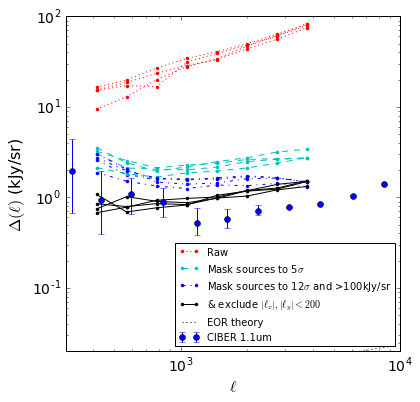

In [12]:
stys = ['r.:','c.--','b.-.','k.-']
matplotlib.rcParams.update({'font.size': 14})

plt.figure(figsize=(6,6))
labels = ['Raw','Mask sources to 5$\sigma$','Mask sources to 12$\sigma$ and >100kJy/sr','& exclude $|\ell_x|,|\ell_y|<200$' ]

for framei in range(4):
    for j in range(4):
        l = labels[j] if framei == 0 else ''
        lbins,pspec,img_kjy_per_sr_meansub,masked_img_zoom = lbins_pspec_img_zoom_list[framei][j]
        plt.loglog(lbins,sqrt(lbins**2*pspec/(2*pi)),stys[j],label=l)

plt.errorbar(ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1],yerr=[np.abs(ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1]),\
                                                                 np.abs(ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1])],fmt='o',label='CIBER 1.1um')

plt.loglog(ell_Cell_eormodel[:,0],ell_Cell_eormodel[:,1],'k:',label='EOR theory')

plt.legend(fontsize=10,loc=4)
plt.ylim([.02,100])
plt.xlim([300,1.e4])
plt.xlabel('$\ell$',fontsize=16)
plt.ylabel('$\Delta(\ell)$ (kJy/sr)',fontsize=16)

plt.savefig('big_foreground_masking_study_pspecs.pdf',bbox_inches='tight')


dl = 90


/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: divide by zero encountered in log10



dl = 90

dl = 90

dl = 90


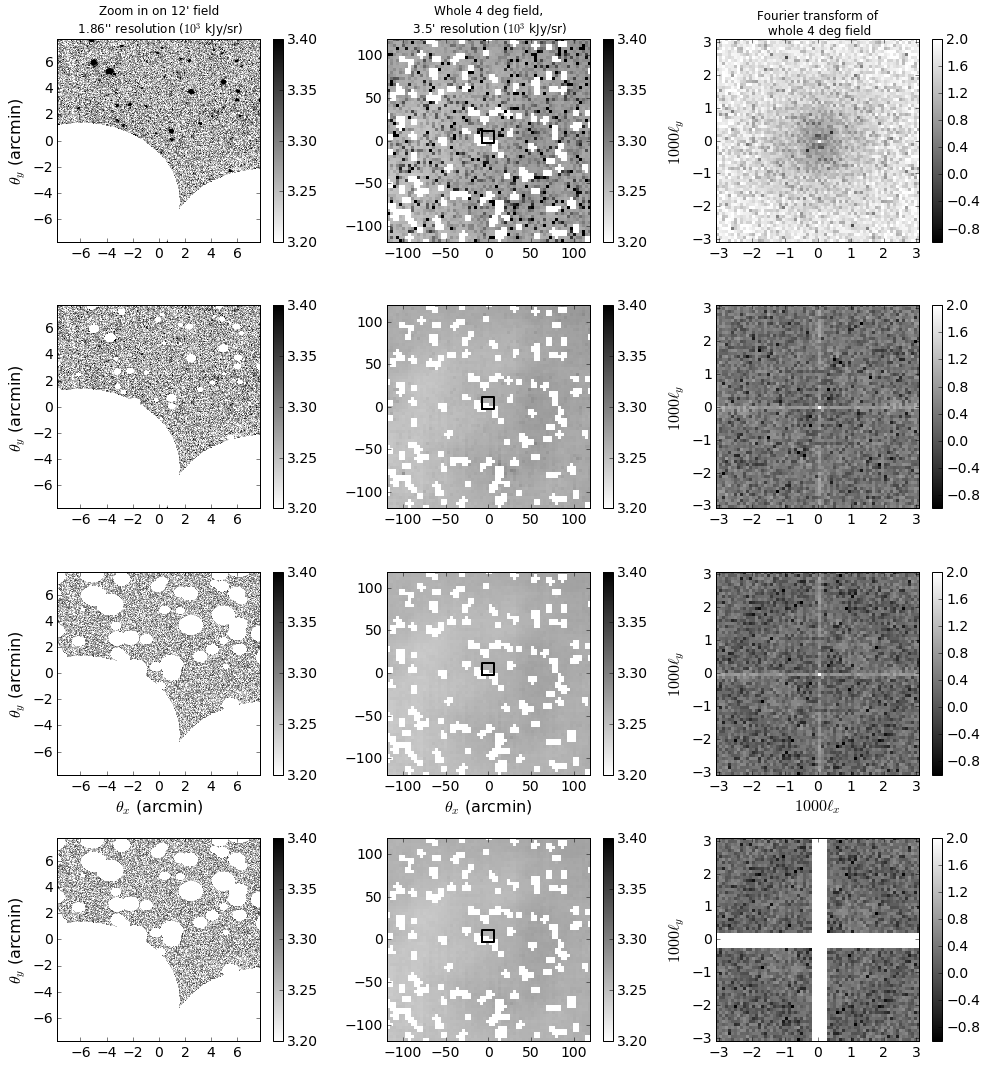

In [39]:
fig = plt.figure(figsize=(14,15))

magzpt,exp_time_sec = 20.56,30
dtheta_rad = asec_per_pixel/3600.*np.pi/180
adu2kjy_per_sr = 3.631*(10**(-magzpt/2.5))/exp_time_sec/dtheta_rad**2

transFigure = fig.transFigure.inverted()

for j in range(4):
    lbins,pspec,img_kjy_per_sr,masked_img_zoom = lbins_pspec_img_zoom_list[0][j]
        
    plt.subplot(4,3,3*j+1)
    ax1 = plt.gca()
    d=500
    plt.imshow(adu2kjy_per_sr*masked_img_zoom[0:d,200:200+d]/1.e3,interpolation='nearest',cmap='gray_r',rasterized=True,\
              vmin=3.2,vmax=3.4,extent=[-asec_per_pixel/60*d/2,asec_per_pixel/60*d/2,-asec_per_pixel/60*d/2,asec_per_pixel/60*d/2])
    cbar = plt.colorbar()
    cbar.set_ticks(3.2+.05*np.arange(5))
    plt.ylabel('$\\theta_y$ (arcmin)',fontsize=16)
    if j == 2: plt.xlabel('$\\theta_x$ (arcmin)',fontsize=16)
    if j == 0: plt.title('Zoom in on 12\' field\n 1.86\'\' resolution ($10^3$ kJy/sr)',fontsize=12)
    
    ###################################################
    plt.subplot(4,3,3*j+2)
    ax2 = plt.gca()
    n_coarse = img_kjy_per_sr.shape[0]
    dtheta_coarse_amin = 3.5
    dtheta_coarse_rad = dtheta_coarse_amin/60.*np.pi/180
    plt.imshow(img_kjy_per_sr/1.e3,interpolation='nearest',cmap='gray_r',vmin=3.2,vmax=3.4,rasterized=True,\
              extent=[-dtheta_coarse_amin*n_coarse/2,dtheta_coarse_amin*n_coarse/2,-dtheta_coarse_amin*n_coarse/2,dtheta_coarse_amin*n_coarse/2])
    cbar = plt.colorbar()
    cbar.set_ticks(3.2+.05*np.arange(5))
    if j == 2: plt.xlabel('$\\theta_x$ (arcmin)',fontsize=16)
    if j == 0: plt.title('Whole 4 deg field,\n 3.5\' resolution ($10^3$ kJy/sr)',fontsize=12)

    dy = 1.25*dtheta_coarse_amin
    plt.plot(np.array([-2*dtheta_coarse_amin,-2*dtheta_coarse_amin,2*dtheta_coarse_amin,2*dtheta_coarse_amin,-2*dtheta_coarse_amin]),\
            np.array([-2*dtheta_coarse_amin,2*dtheta_coarse_amin,2*dtheta_coarse_amin,-2*dtheta_coarse_amin,-2*dtheta_coarse_amin])+dy,'k',linewidth=2)
    plt.xlim([-dtheta_coarse_amin*n_coarse/2,dtheta_coarse_amin*n_coarse/2])
    plt.ylim([-dtheta_coarse_amin*n_coarse/2,dtheta_coarse_amin*n_coarse/2])
    
#     # draw lines for zoom box
    
#     coord1 = transFigure.transform(ax1.transData.transform([0,0]))
#     coord2 = transFigure.transform(ax2.transData.transform([-2*dtheta_coarse_amin,-2*dtheta_coarse_amin+dy]))

#     line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
#                                    transform=fig.transFigure)
#     fig.lines.append(line,)
    
    ##################################################
    plt.subplot(4,3,3*j+3)
    pspec_norm = (dtheta_coarse_rad**2)/(n_coarse**2)
    img_kjy_per_sr_meansub = array(img_kjy_per_sr)
    img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0] -= np.mean(img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0])
    pspec2d = np.abs(np.fft.fft2(img_kjy_per_sr_meansub))**2*pspec_norm
    
    lvals = fft.fftfreq(n_coarse)*2*pi/dtheta_coarse_rad # ell values
    dl = np.abs(lvals[1]-lvals[0])
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)
    delta = np.fft.fftshift(sqrt(lmaggrid**2*pspec2d/(2*pi)))
    
    if j == 3: delta *= 1.*np.fft.fftshift((np.abs(lxgrid)>2*dl)*(np.abs(lygrid)>2*dl))
    
    plt.imshow(np.log10(delta),vmin=-1,vmax=2,rasterized=True,\
               interpolation='nearest',cmap='gray',extent=[-n_coarse/2*dl/1.e3,n_coarse/2*dl/1.e3,-n_coarse/2*dl/1.e3,n_coarse/2*dl/1.e3])
    if j == 0: plt.title('Fourier transform of\n whole 4 deg field',fontsize=12)
    plt.ylabel('$1000\ell_y$',fontsize=16)
    if j == 2: plt.xlabel('$1000\ell_x$',fontsize=16)
    plt.colorbar()
    
        
    plt.xlim([-n_coarse/2*dl/1.e3,n_coarse/2*dl/1.e3])
    plt.ylim([-n_coarse/2*dl/1.e3,n_coarse/2*dl/1.e3])
    
plt.tight_layout()
#plt.savefig('big_foreground_masking_study.pdf',bbox_inches='tight')

In [36]:
fig.lines

[]

In [147]:
10*adu2kjy_per_sr

88.864719034976289

In [148]:
dl

90.756302521008394